In [21]:
"""
Classifying roof materials for building footprints from trained ResNet-18 models
Author: maxwell.cook@colorado.edu
"""

import sys, os, gc, time
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchsat.models.classification import resnet18
from torch.nn.functional import softmax
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Custom functions (__functions.py)
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'
homedir = '/home/jovyan' # cyverse

# results_dir = os.path.join(maindir, 'results/resnet18/')
results_dir = os.path.join(homedir, 'results/resnet18-cv/')
print(results_dir)

print("Imports successful !")

/home/jovyan/results/resnet18-cv/
Imports successful !


In [22]:
# Best params from tuning
params = {'window_size': 78, 'batch_size': 64, 'learning_rate': 0.01, 'weight_decay': 0.01, 'momentum': 0.85, 'patience': 5}
print(f'Model params: {params}')

Model params: {'window_size': 78, 'batch_size': 64, 'learning_rate': 0.01, 'weight_decay': 0.01, 'momentum': 0.85, 'patience': 5}


In [23]:
# Load MS building footprint data

In [24]:
# fp = os.path.join(maindir, 'data/spatial/raw/dc_data/footprints/dc-ms_footprints.gpkg')
fp = os.path.join(homedir, 'opp-data/dc-ms_footprints.gpkg')
footprints = gpd.read_file(fp)
footprints['uid'] = footprints.index + 1
footprints = footprints[['uid', 'geometry']]
footprints.head()

,uid,geometry
0,1,"POLYGON ((334794.168 4306846.311, 334799.662 4..."
1,2,"POLYGON ((334703.572 4306870.743, 334701.114 4..."
2,3,"POLYGON ((334666.123 4306432.288, 334671.751 4..."
3,4,"POLYGON ((334616.324 4306162.858, 334621.692 4..."
4,5,"POLYGON ((334622.665 4306603.184, 334630.936 4..."


In [25]:
footprints.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [26]:
# Load the sampled data as well (holdout)

In [27]:
# Load the holdout data
# holdout_df = gpd.read_file(os.path.join(homedir,'results/resnet18/cv-results/dc-resnet18_cv_holdout_ref.gpkg'))
holdout_df = gpd.read_file(os.path.join(results_dir, 'dc-resnet18_cv_holdout_ref.gpkg'))
print("Holdout set class distribution:\n", holdout_df[['class_code','code']].value_counts())

Holdout set class distribution:
 class_code  code
CS          0       7427
ME          1       7373
SL          2       3054
UR          3        256
WS          5        231
TL          4        185
SH          6        157
Name: count, dtype: int64


In [28]:
# Create dictionaries for mapping
code_mapping = dict(zip(holdout_df['code'], holdout_df['class_code']))  # Mapping to original 'class_code'
desc_mapping = dict(zip(holdout_df['code'], holdout_df['description']))
print(f'Code map: \n{code_mapping}\nDescription map: \n{desc_mapping}')

Code map: 
{0: 'CS', 1: 'ME', 2: 'SL', 3: 'UR', 4: 'TL', 5: 'WS', 6: 'SH'}
Description map: 
{0: 'Composition Shingle', 1: 'Metal', 2: 'Slate', 3: 'Urethane', 4: 'Tile', 5: 'Wood shake/shingle', 6: 'Shingle'}


In [29]:
# Load the Planet imagery

In [30]:
# Load our image data to check on the format
# stack_da_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_final_norm.tif')
stack_da_fp = os.path.join(homedir,'opp-data/dc_0623_psscene8b_final_norm.tif')
stack_da = rxr.open_rasterio(stack_da_fp, mask=True, cache=False).squeeze()
n_bands = stack_da.values.shape[:1][0] # get a list of band names
print(
    f"shape: {stack_da.rio.shape}\n"
    f"bands: {n_bands}\n"
    f"resolution: {stack_da.rio.resolution()}\n"
    f"bounds: {stack_da.rio.bounds()}\n"
    f"sum: {stack_da.sum().item()}\n"
    f"CRS: {stack_da.rio.crs}\n"
    f"NoData: {stack_da.rio.nodata}\n"
    f"Array: {stack_da}"
)
del stack_da

shape: (8223, 6714)
bands: 6
resolution: (3.0, -3.0)
bounds: (315267.0, 4294629.0, 335409.0, 4319298.0)
sum: 8.181640625
CRS: EPSG:32618
NoData: None
Array: <xarray.DataArray (band: 6, y: 8223, x: 6714)> Size: 1GB
[331255332 values with dtype=float32]
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 54kB 3.153e+05 3.153e+05 ... 3.354e+05 3.354e+05
  * y            (y) float64 66kB 4.319e+06 4.319e+06 ... 4.295e+06 4.295e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5')


In [31]:
# Create the roof image dataset for inference (all MS building footprints)

In [32]:
# Custom collate function to handle Tensors and shapely.geometry.Polygon objects
def custom_collate(batch):
    images = torch.stack([item['image'] for item in batch], dim=0)  # Batch the images (Tensors)
    bboxes = [item['bbox'] for item in batch]  # Keep bounding boxes as a list (don't batch them)
    return {'image': images, 'bbox': bboxes}

In [33]:
footprints_ds = UnlabeledRoofImageDataset(footprints, img_path=stack_da_fp, n_bands=n_bands, img_dim=params['window_size'])
dloader = DataLoader(
    footprints_ds, 
    batch_size=params['batch_size']*2, 
    num_workers=2, 
    shuffle=False, 
    pin_memory=True,
    collate_fn=custom_collate # allow retrieving the bbox
)
print("Data loaded for all footprints !")

Data loaded for all footprints !


In [34]:
# Initialize the ResNet-18 model

In [35]:
# Define whether to leverage cpu or gpu (for my local machine it is only cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
print(f'Using {device} for model eval ...')

Using cuda for model eval ...


In [36]:
# Load the trained model for the current fold
best_fold = 4  # from holdout accuracy
# model_fp = os.path.join(maindir,f'results/resnet18/cv-models/dc-resnet18_fold{best_fold}.pth')
model_fp = os.path.join(results_dir, f'dc-resnet18_fold{best_fold}.pth')

print(f"Loading model from path: {model_fp}")
checkpoint = torch.load(model_fp, map_location=device)

# Initialize the model architecture
n_classes = len(code_mapping.keys())
model, _, _, _ = initialize_resnet18(
    n_classes=n_classes,
    n_channels=n_bands,
    device=device,
    params=params
)

# Load the trained weights
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set the model to evaluation mode
print("\tModel loaded !")

Loading model from path: /home/jovyan/results/resnet18-cv/dc-resnet18_fold4.pth
	Made GPU parallel.
	Model loaded !


In [37]:
# Create a dataframe to store the results
n = footprints_ds.__len__() # length of the dataset
print(f"Length of footprint dataset: {n}")
class_labels = [code_mapping[i] for i in range(n_classes)]
columns = ['chunk_idx', 'bbox', 'prediction', 'confidence'] + class_labels
res_df = pd.DataFrame(columns=columns)
res_df.head(3)

Length of footprint dataset: 77851


,chunk_idx,bbox,prediction,confidence,CS,ME,SL,UR,TL,WS,SH


In [38]:
t0 = time.time()

# Run inference
with torch.no_grad():
    for batch_idx, sample in enumerate(dloader):
        image = sample['image'].to(device) # retrieve the image chunks (unlabeled)
        bboxes = sample['bbox']  # Get the bounding boxes for the image chunks

        # Make predictions
        output = model(image.float())
        probabilities = softmax(output, dim=1).cpu().numpy()  # Get probabilities for all classes
        predictions = output.argmax(dim=1).cpu().numpy() # the predicted class
        confidence = probabilities.max(axis=1)  # max probability for the predicted class

        # Assign predictions and probabilities to all footprints that intersect with the bounding box
        batch_results = [] # store results for each chunk
        for i, bbox in enumerate(bboxes):
            prob_dict = {code_mapping[j]: probabilities[i, j] for j in range(n_classes)}  # Use class names as column headers
            batch_results.append({
                'chunk_idx': batch_idx * params['batch_size'] + i,  # Optional chunk ID
                'bbox': bbox,  # Bounding box of the chunk
                'prediction': code_mapping[predictions[i]],  # Map prediction to class name
                'confidence': confidence[i],
                **prob_dict  # Include all class probabilities with class names as column headers
            })

        batch_df = pd.DataFrame(batch_results)
        res_df = pd.concat([res_df, batch_df], ignore_index=True)
        
        if batch_idx % 10 == 0:
            print(f"\tProcessed {batch_idx * params['batch_size']} samples.")

        # Clear GPU memory after each batch
        torch.cuda.empty_cache()
        gc.collect()

print("\n~~~~~~~~~~\n")
t2 = (time.time() - t0) / 60
print(f"Total elapsed time for inference: {t2:.2f} minutes.")
print("\n~~~~~~~~~~\n")

	Processed 0 samples.
	Processed 640 samples.
	Processed 1280 samples.
	Processed 1920 samples.
	Processed 2560 samples.
	Processed 3200 samples.
	Processed 3840 samples.
	Processed 4480 samples.
	Processed 5120 samples.
	Processed 5760 samples.
	Processed 6400 samples.
	Processed 7040 samples.
	Processed 7680 samples.
	Processed 8320 samples.
	Processed 8960 samples.
	Processed 9600 samples.
	Processed 10240 samples.
	Processed 10880 samples.
	Processed 11520 samples.
	Processed 12160 samples.
	Processed 12800 samples.
	Processed 13440 samples.
	Processed 14080 samples.
	Processed 14720 samples.
	Processed 15360 samples.
	Processed 16000 samples.
	Processed 16640 samples.
	Processed 17280 samples.
	Processed 17920 samples.
	Processed 18560 samples.
	Processed 19200 samples.
	Processed 19840 samples.
	Processed 20480 samples.
	Processed 21120 samples.
	Processed 21760 samples.
	Processed 22400 samples.
	Processed 23040 samples.
	Processed 23680 samples.
	Processed 24320 samples.
	Proce

In [39]:
res_df.head()

,chunk_idx,bbox,prediction,confidence,CS,ME,SL,UR,TL,WS,SH
0,0,"POLYGON ((334917 4306731, 334917 4306965, 3346...",CS,0.988314,0.988314,0.001325,0.001592,0.000181,0.000233,0.000027,0.008327
1,1,"POLYGON ((334812 4306749, 334812 4306983, 3345...",CS,0.997035,0.997035,0.000732,0.000694,0.000014,0.000092,0.001233,0.000200
2,2,"POLYGON ((334782 4306323, 334782 4306557, 3345...",CS,0.629269,0.629269,0.006650,0.076365,0.001589,0.266676,0.002593,0.016858
3,3,"POLYGON ((334731 4306053, 334731 4306287, 3344...",CS,0.931676,0.931676,0.002242,0.055915,0.002766,0.001167,0.005692,0.000543
4,4,"POLYGON ((334740 4306494, 334740 4306728, 3345...",CS,0.950600,0.950600,0.010073,0.030565,0.000514,0.003937,0.000123,0.004187


In [41]:
out_fp = os.path.join(results_dir,'classification/')
if not os.path.exists(out_fp):
    os.makedirs(out_fp)
out_fp = os.path.join(out_fp,'dc-resnet18-inference_ms-footprints.csv')
res_df.to_csv(out_fp, index=False)
print(f"Saved to {out_fp}")

Saved to /home/jovyan/results/resnet18-cv/classification/dc-resnet18-inference_ms-footprints.csv


In [ ]:
# Transfer to footprint data

In [42]:
# Convert results to a GeoDataFrame
res_gdf = gpd.GeoDataFrame(res_df, geometry=res_df['bbox'], crs=footprints.crs)

# Perform a spatial join to the footprints
res_gdf_footprints = gpd.sjoin(footprints, res_gdf, how="left", predicate="intersects")

# Group by footprint UID and calculate the mean of probabilities for overlapping chunks
agg_dict = {class_name: 'mean' for class_name in class_labels}
agg_dict.update({
    'confidence': 'mean',  # Calculate mean confidence
    'prediction': lambda x: x.mode()[0]  # Use the most common prediction (mode)
})

# Aggregate by footprint ID
agg_results = res_gdf_footprints.groupby('uid').agg(agg_dict).reset_index()
# Merge back to the original footprint data
inference_results = footprints.merge(agg_results, on='uid', how='left')
inference_results = inference_results[['uid','prediction','confidence']+class_labels+['geometry']] 	

# Save out
out_fp = os.path.join(results_dir, 'dc-resnet18-inference_ms-footprints_mean.gpkg')
inference_results.to_file(out_fp)
inference_results.head()

,uid,prediction,confidence,CS,ME,SL,UR,TL,WS,SH,geometry
0,1,CS,0.938670,0.932819,0.004881,0.005791,0.001234,0.002956,0.032270,0.020047,"POLYGON ((334794.168 4306846.311, 334799.662 4..."
1,2,CS,0.951564,0.951138,0.003498,0.004728,0.001179,0.001276,0.015694,0.022486,"POLYGON ((334703.572 4306870.743, 334701.114 4..."
2,3,CS,0.855312,0.836960,0.005624,0.113026,0.002095,0.009412,0.021802,0.011080,"POLYGON ((334666.123 4306432.288, 334671.751 4..."
3,4,CS,0.829231,0.827656,0.004210,0.126863,0.001677,0.003047,0.025353,0.011194,"POLYGON ((334616.324 4306162.858, 334621.692 4..."
4,5,CS,0.942368,0.930119,0.012943,0.015518,0.019357,0.002538,0.011083,0.008442,"POLYGON ((334622.665 4306603.184, 334630.936 4..."


In [ ]:
# Join to the reference data to check the accuracy

In [43]:
# Load the training data (footprints)
# gdf_path = os.path.join(maindir,'data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg')
gdf_path = os.path.join(homedir,'opp-data/dc_data_reference_footprints.gpkg')
ref = gpd.read_file(gdf_path)
ref.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,geometry
0,1CS,CS,Composition Shingle,357.783709,5574.0,"POLYGON ((324215.868 4313568.665, 324215.792 4..."
1,3CS,CS,Composition Shingle,918.640862,1111.0,"POLYGON ((324602.816 4311717.247, 324604.322 4..."
2,9CS,CS,Composition Shingle,1383.414170,4222.0,"POLYGON ((327253.581 4300371.859, 327258.154 4..."
3,19CS,CS,Composition Shingle,836.410297,3450.0,"POLYGON ((333608.13 4306267.691, 333607.957 43..."
4,27CS,CS,Composition Shingle,330.514264,4352.0,"POLYGON ((326482.699 4300939.466, 326487.386 4..."


In [44]:
# Merge to the classified footprints by centroid
ref['geometry'] = ref.geometry.centroid
inference_ref = gpd.sjoin(inference_results, ref, how='left', predicate='intersects')
inference_ref.columns

Index(['uid_left', 'prediction', 'confidence', 'CS', 'ME', 'SL', 'UR', 'TL',
       'WS', 'SH', 'geometry', 'index_right', 'uid_right', 'class_code',
       'description', 'areaUTMsqft', 'lotSizeSqft'],
      dtype='object')

In [45]:
inference_ref.drop(columns=['index_right'], inplace=True)
inference_ref.rename(columns={'uid_right': 'ref_id', 'uid_left': 'fp_id'}, inplace=True)
# Check NaN (i.e., no matches with reference data)
print(f"There are [{inference_ref['ref_id'].isna().sum()}/{len(inference_ref)}] NaN records.")

There are [34657/107241] NaN records.


In [46]:
inference_ref_ = inference_ref.dropna(subset=['ref_id'])
inference_ref_.head()

,fp_id,prediction,confidence,CS,ME,SL,UR,TL,WS,SH,geometry,ref_id,class_code,description,areaUTMsqft,lotSizeSqft
8,9,CS,0.861619,0.799832,0.089344,0.059942,0.005612,0.005500,0.014218,0.025551,"POLYGON ((334296.135 4306681.299, 334296.163 4...",123513CS,CS,Composition Shingle,489.730792,1548.0
8,9,CS,0.861619,0.799832,0.089344,0.059942,0.005612,0.005500,0.014218,0.025551,"POLYGON ((334296.135 4306681.299, 334296.163 4...",154220CS,CS,Composition Shingle,473.821528,1192.0
12,13,CS,0.737934,0.696484,0.068868,0.146008,0.011660,0.008549,0.042870,0.025562,"POLYGON ((334139.718 4306575.1, 334131.485 430...",90195CS,CS,Composition Shingle,430.686443,2716.0
12,13,CS,0.737934,0.696484,0.068868,0.146008,0.011660,0.008549,0.042870,0.025562,"POLYGON ((334139.718 4306575.1, 334131.485 430...",109424CS,CS,Composition Shingle,414.076980,2716.0
15,16,CS,0.633103,0.461443,0.288476,0.152417,0.017894,0.006999,0.029296,0.043476,"POLYGON ((334006.354 4306720.017, 334005.934 4...",147803CS,CS,Composition Shingle,1698.902618,7000.0


In [ ]:
# Plot the distribution of accuracy by class

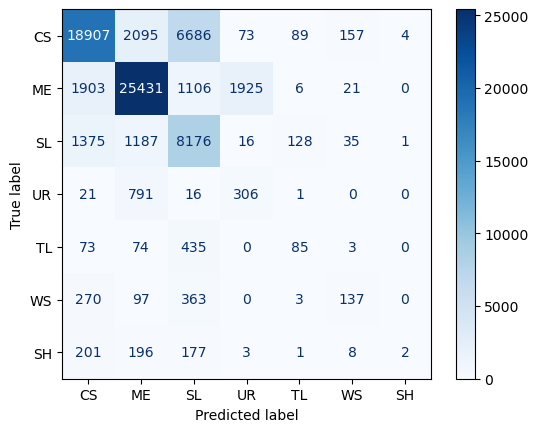

In [47]:
y_true = inference_ref_['class_code']  # True labels from the reference dataset
y_pred = inference_ref_['prediction']  # Predicted labels from your inference results

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=ref['class_code'].unique())

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ref['class_code'].unique())
disp.plot(cmap=plt.cm.Blues)

# Save the plot
out_png = os.path.join(results_dir, 'classification/dc-resnet18-inference_ms-footprints_confmat.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [48]:
# Generate classification report
report_dict = classification_report(y_true, y_pred, target_names=ref['class_code'].unique(), output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

report_df

,precision,recall,f1-score,support
CS,0.831077,0.674985,0.744942,28011.000000
ME,0.851361,0.836766,0.844000,30392.000000
SL,0.285714,0.003401,0.006723,588.000000
UR,0.482104,0.748855,0.586577,10918.000000
TL,0.271565,0.126866,0.172940,670.000000
WS,0.131726,0.269604,0.176981,1135.000000
SH,0.379501,0.157471,0.222583,870.000000
accuracy,0.730795,0.730795,0.730795,0.730795
macro avg,0.461864,0.402564,0.393535,72584.000000
weighted avg,0.761147,0.730795,0.736196,72584.000000


In [49]:
# Save the classification report
out_fp = os.path.join(results_dir,'classification/dc-resnet18-inference_ms-footprints_report.csv')
report_df.to_csv(out_fp)

In [ ]:
# Bar plot of F1-score

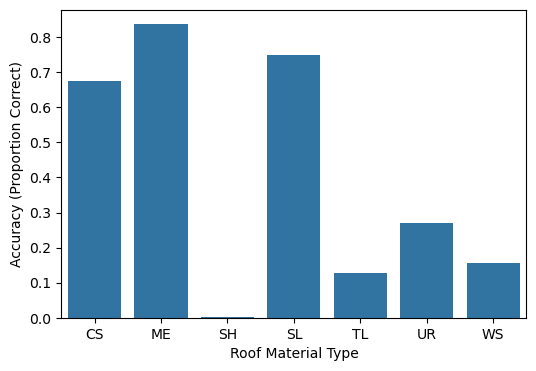

In [50]:
inference_ref_['agreement'] = inference_ref_['class_code'] == inference_ref_['prediction']
acc = inference_ref_.groupby('class_code')['agreement'].mean().reset_index()

# Plot the agreement percentages by class
plt.figure(figsize=(6, 4))
sns.barplot(x='class_code', y='agreement', data=acc)
plt.ylabel('Accuracy (Proportion Correct)')
plt.xlabel('Roof Material Type')

# Save the plot
out_png = os.path.join(results_dir, 'classification/dc-resnet18-inference_ms-footprints_accuracy.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [51]:
gc.collect()

245